In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/used-cars-simplified/used_cars_simplified.csv


***Data Loading***

In [2]:
df_train= pd.read_csv("../input/used-cars-simplified/used_cars_simplified.csv")

In [3]:
df_train.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,brand,model,model_year,milage,fuel_type,ext_col,int_col,accident,clean_title,price,engine_displacement_l,engine_cylinders,transmission_type
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,Black,Black,At least 1 accident or damage reported,Yes,"$10,300",3.7,6.0,Automatic
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005",3.8,6.0,Automatic
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,Blue,Black,None reported,NaN,"$54,598",3.5,NaN,Automatic
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,Black,Black,None reported,Yes,"$15,500",3.5,6.0,Automatic
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,Glacier White Metallic,Black,None reported,NaN,"$34,999",2.0,4.0,Automatic


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   brand                  4009 non-null   object 
 1   model                  4009 non-null   object 
 2   model_year             4009 non-null   int64  
 3   milage                 4009 non-null   object 
 4   fuel_type              3839 non-null   object 
 5   ext_col                4009 non-null   object 
 6   int_col                4009 non-null   object 
 7   accident               3896 non-null   object 
 8   clean_title            3413 non-null   object 
 9   price                  4009 non-null   object 
 10  engine_displacement_l  3792 non-null   float64
 11  engine_cylinders       3573 non-null   float64
 12  transmission_type      4009 non-null   object 
dtypes: float64(2), int64(1), object(10)
memory usage: 407.3+ KB


In [5]:
df_train.describe()

,model_year,engine_displacement_l,engine_cylinders
count,4009.000000,3792.000000,3573.000000
mean,2015.515590,3.805301,6.226700
std,6.104816,3.101495,1.721055
min,1974.000000,1.000000,3.000000
25%,2012.000000,2.500000,4.000000
50%,2017.000000,3.500000,6.000000
75%,2020.000000,4.700000,8.000000
max,2024.000000,75.000000,16.000000


****Data Preprocessing****

Handling outliers

In [6]:

def remove_outliers_iqr(df, columns=None):
    if columns is None:
        columns = df.select_dtypes(include=['number']).columns.tolist()
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Reassign df with only rows inside the bounds
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    df = df.reset_index(drop=True)  # Reset index
    return df

print("Original shape:", df_train.shape)

df = remove_outliers_iqr(df_train)

print("After removing outliers:", df_train.shape)


Original shape: (4009, 13)
After removing outliers: (4009, 13)


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


Imputing missing numerical values using KNN imputers to preserve multivariate features

In [7]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


print("--- df_train Before Imputation ---")
print(df_train.head())
print("\nMissing values in df_train before imputation:")
print(df_train.isnull().sum())


numerical_cols = df_train.select_dtypes(include=np.number).columns
categorical_cols = df_train.select_dtypes(exclude=np.number).columns

df_numerical = df_train[numerical_cols]
df_categorical = df_train[categorical_cols]



scaler = StandardScaler()

knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')

pipeline = Pipeline([
    ('scaler', scaler),
    ('imputer', knn_imputer)
])


imputed_numerical_data_scaled = pipeline.fit_transform(df_numerical)

imputed_numerical_data = pipeline.named_steps['scaler'].inverse_transform(imputed_numerical_data_scaled)

df_numerical_imputed = pd.DataFrame(imputed_numerical_data, columns=numerical_cols)

df_train = pd.concat([df_numerical_imputed, df_categorical.reset_index(drop=True)], axis=1)

df_train = df_train[df_train.columns]

print("\n\n--- df_train After Imputation ---")
print(df_train.head())
print("\nMissing values after imputation (checking the updated df_train):")
print(df_train.isnull().sum())


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


--- df_train Before Imputation ---
      brand                            model  model_year      milage  \
0      Ford  Utility Police Interceptor Base        2013  51,000 mi.   
1   Hyundai                     Palisade SEL        2021  34,742 mi.   
2     Lexus                    RX 350 RX 350        2022  22,372 mi.   
3  INFINITI                 Q50 Hybrid Sport        2015  88,900 mi.   
4      Audi        Q3 45 S line Premium Plus        2021   9,835 mi.   

       fuel_type                 ext_col int_col  \
0  E85 Flex Fuel                   Black   Black   
1       Gasoline         Moonlight Cloud    Gray   
2       Gasoline                    Blue   Black   
3         Hybrid                   Black   Black   
4       Gasoline  Glacier White Metallic   Black   

                                 accident clean_title    price  \
0  At least 1 accident or damage reported         Yes  $10,300   
1  At least 1 accident or damage reported         Yes  $38,005   
2                    

Imputing and encoding the categorical columns. Ordinal encoding encodes according to the importance of columns i.e order of colums.

In [8]:
from sklearn.preprocessing import OrdinalEncoder

cat_fill_values = {}
cat_cols = df_train.select_dtypes(include=["object", "category"]).columns

for col in cat_cols:
    mode_val = df_train[col].mode()[0]    
    cat_fill_values[col] = mode_val
    df_train[col] = df_train[col].fillna(mode_val)

encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

df_train[cat_cols] = encoder.fit_transform(df_train[cat_cols])


Checking if all nulls are imputed

In [9]:
df_train.isnull().sum()

model_year               0
engine_displacement_l    0
engine_cylinders         0
brand                    0
model                    0
milage                   0
fuel_type                0
ext_col                  0
int_col                  0
accident                 0
clean_title              0
price                    0
transmission_type        0
dtype: int64

***Exploratory Data Analysis***

making histograms of the columns

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Skewness of model_year: -1.089


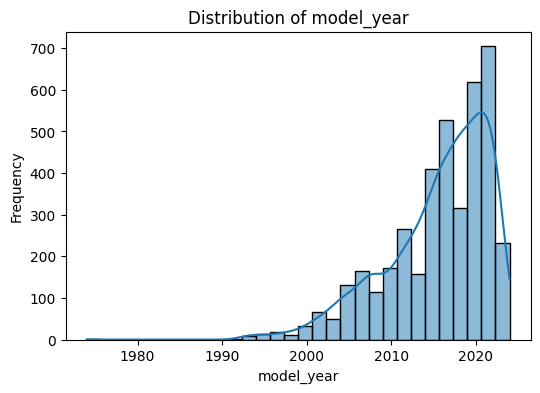

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Skewness of engine_displacement_l: 16.803


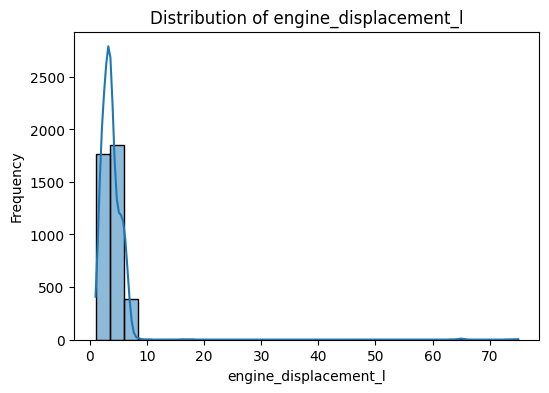

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Skewness of engine_cylinders: 0.370


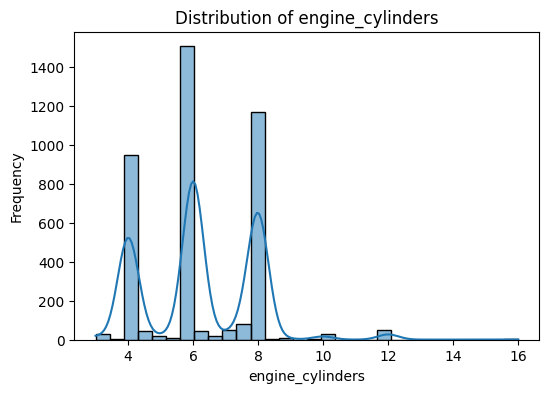

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Skewness of brand: 0.394


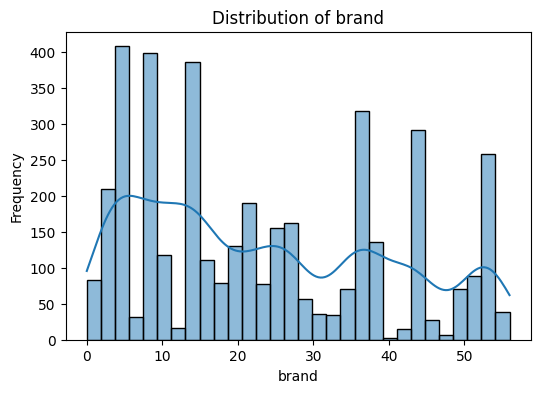

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Skewness of model: 0.079


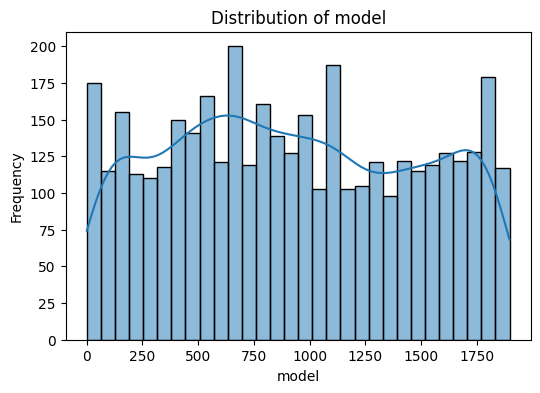

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Skewness of milage: -0.023


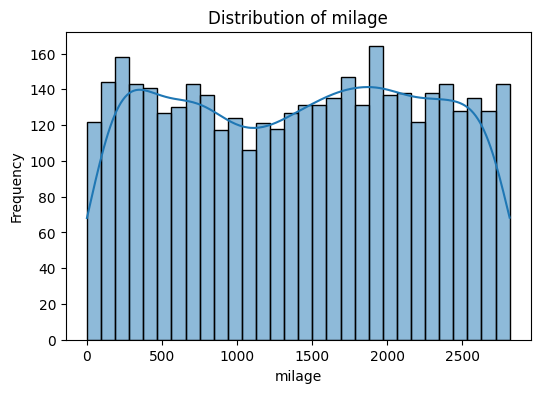

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Skewness of fuel_type: 2.077


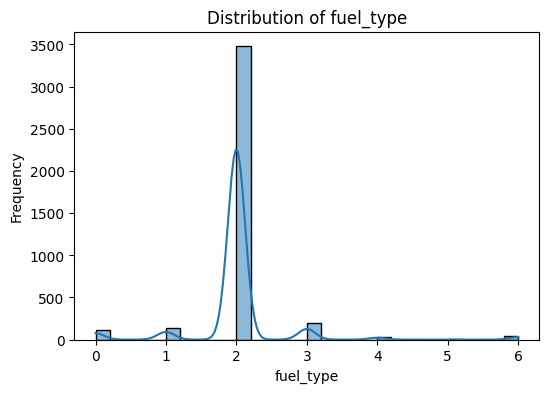

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Skewness of ext_col: 0.104


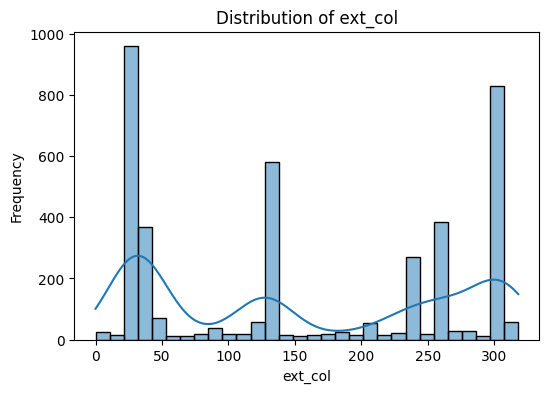

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Skewness of int_col: 1.512


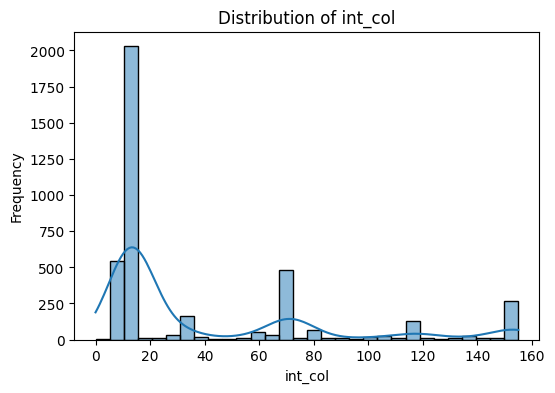

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Skewness of accident: -1.180


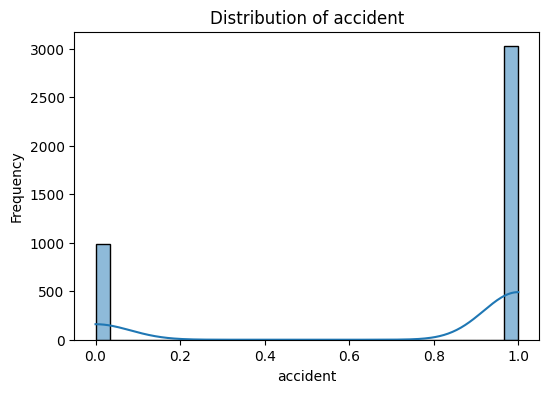

Skewness of clean_title: 0.000


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


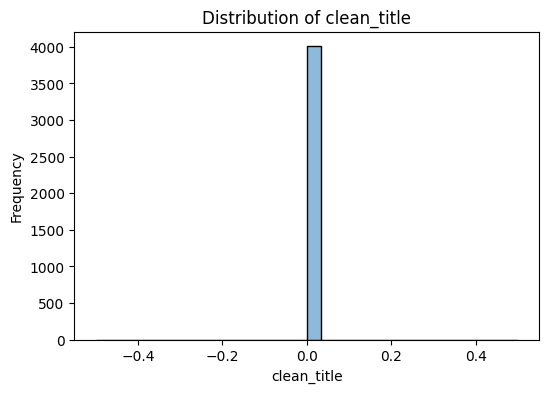

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Skewness of price: 0.115


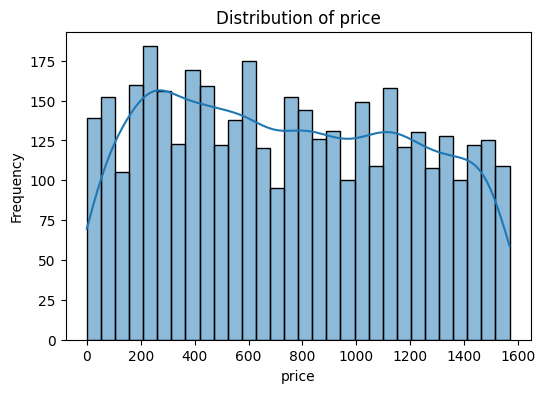

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Skewness of transmission_type: 1.748


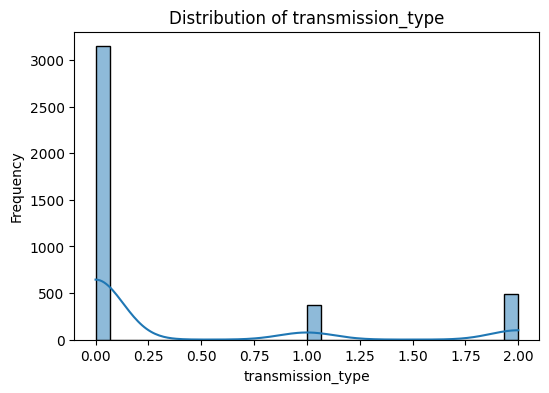

In [10]:
if "LOCAL_IDENTIFIER" in df_train.columns:
    df_train = df_train.drop(columns=["LOCAL_IDENTIFIER"])

for i in df_train.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(6,4))
    
    sns.histplot(df_train[i].dropna(), bins=30, kde=True)
    plt.title(f"Distribution of {i}")
    plt.xlabel(i)
    plt.ylabel("Frequency")
    
    skewness = df_train[i].skew()
    print(f"Skewness of {i}: {skewness:.3f}")
    
    plt.show()

Checking the regression plot of columns with price

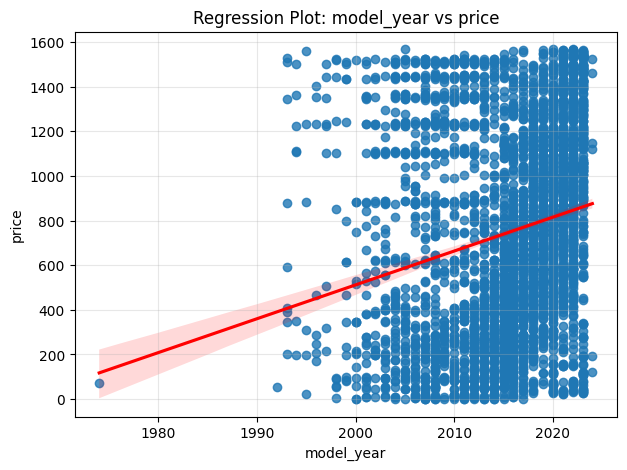

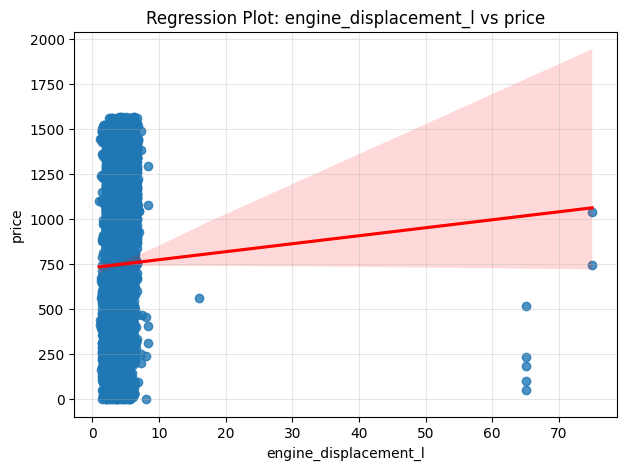

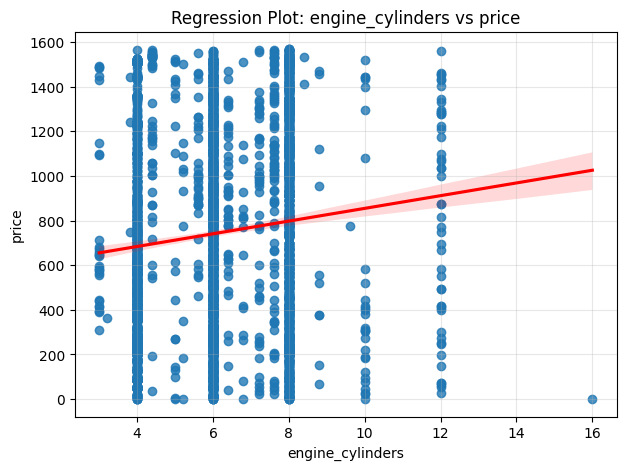

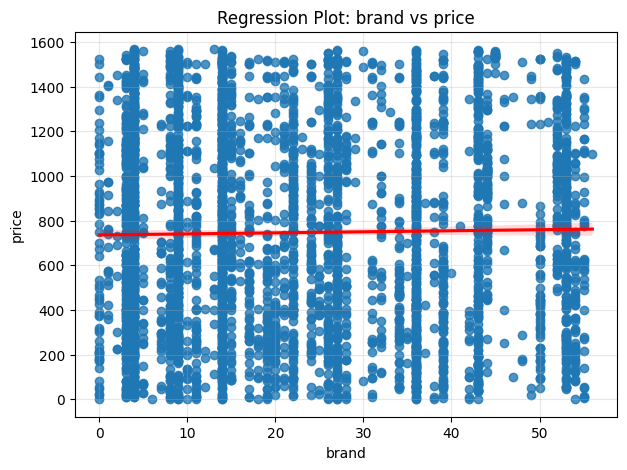

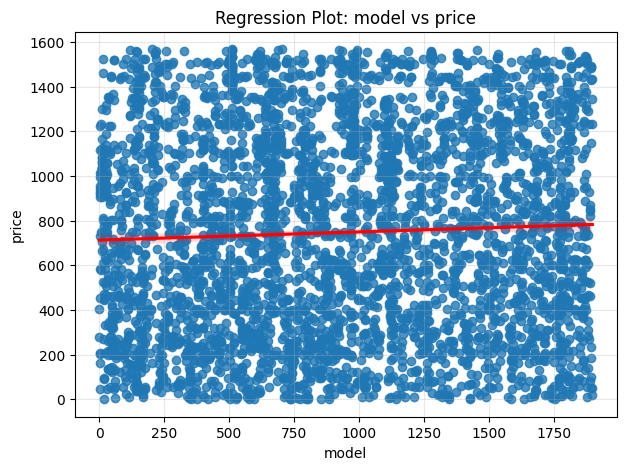

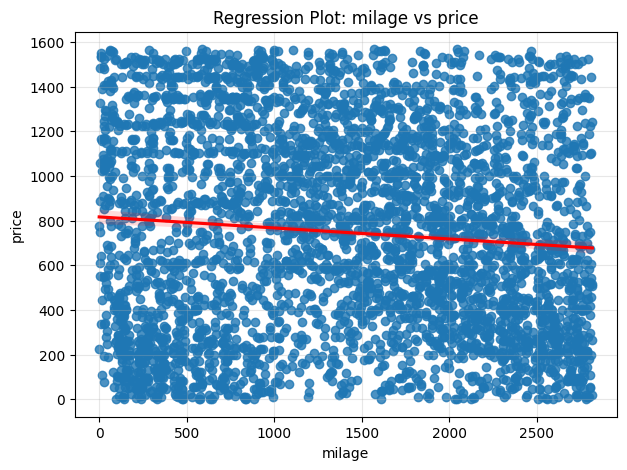

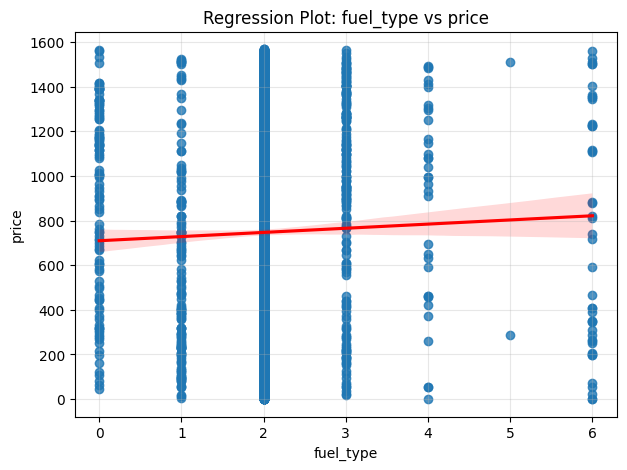

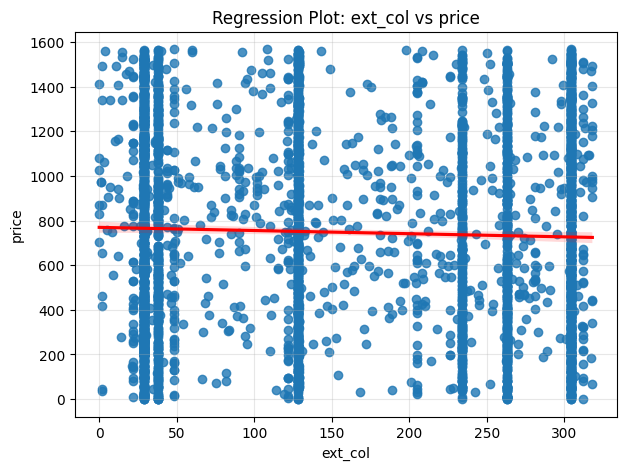

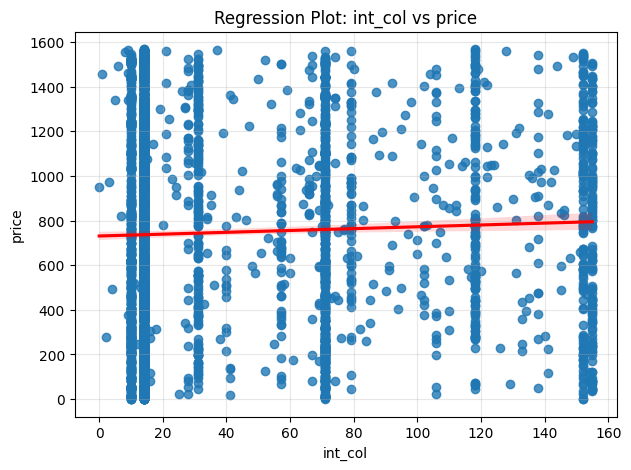

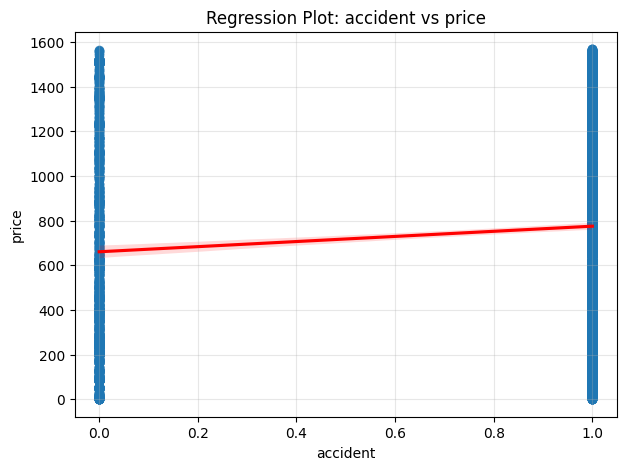

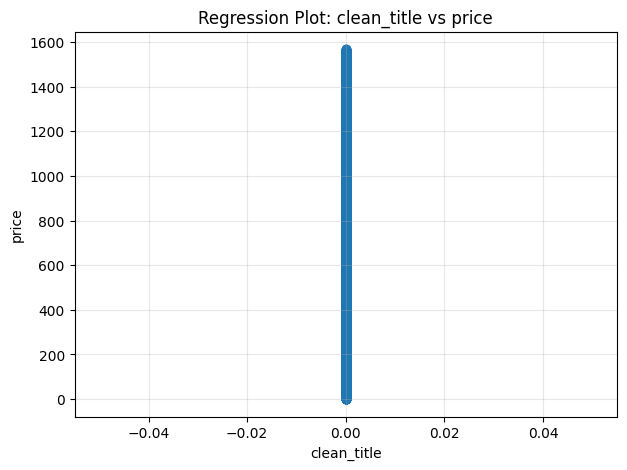

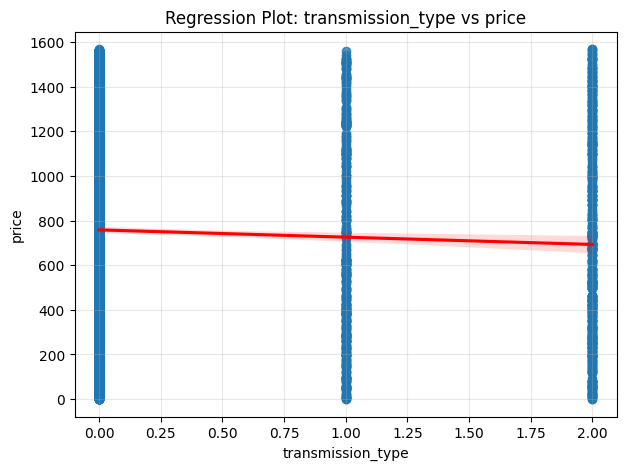

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_regression_against_target(df, target_col):
  
    numeric_cols = df.select_dtypes(include='number').columns.drop(target_col, errors='ignore')
    
    for col in numeric_cols:
        plt.figure(figsize=(7, 5))
        sns.regplot(x=df[col], y=df[target_col], line_kws={"color": "red"})
        plt.title(f"Regression Plot: {col} vs {target_col}")
        plt.xlabel(col)
        plt.ylabel(target_col)
        plt.grid(alpha=0.3)
        plt.show()


plot_regression_against_target(df_train, target_col='price')


Finding correlation of columns with price

In [12]:
import pandas as pd

def correlation_with_target(df, target_col):

    numeric_cols = df.select_dtypes(include='number').columns
    corr = df[numeric_cols].corr()[target_col].sort_values(key=abs, ascending=False)
    return corr

# Example usage:
corr = correlation_with_target(df_train, "price")
print(corr)


price                    1.000000
model_year               0.206274
accident                 0.109945
engine_cylinders         0.106960
milage                  -0.090419
transmission_type       -0.049677
model                    0.045096
int_col                  0.039930
ext_col                 -0.035523
engine_displacement_l    0.029941
fuel_type                0.026793
brand                    0.017063
clean_title                   NaN
Name: price, dtype: float64


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


****Modal building and evaluation****

Used Randomforesstregressor standard scaler to scale all numeric values so that model doesn't confuse, cross vaalidating the scores and trying to use hyperparametr to find the best parameters for thee model to perform. The dataset is splitted into 80% train and 20% test for evaluation of the model and it's predictions.

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors

Cross-Validation R² Scores: [0.29548983 0.2835805  0.40446711 0.33580662 0.34051672]
Mean CV R²: 0.3319721566255576


/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(



Feature-Engineered Random Forest Performance:
R² Score: 0.3454
Mean Squared Error (MSE): 126842.1358
Root Mean Squared Error (RMSE): 356.1490
Mean Absolute Error (MAE): 264.8539


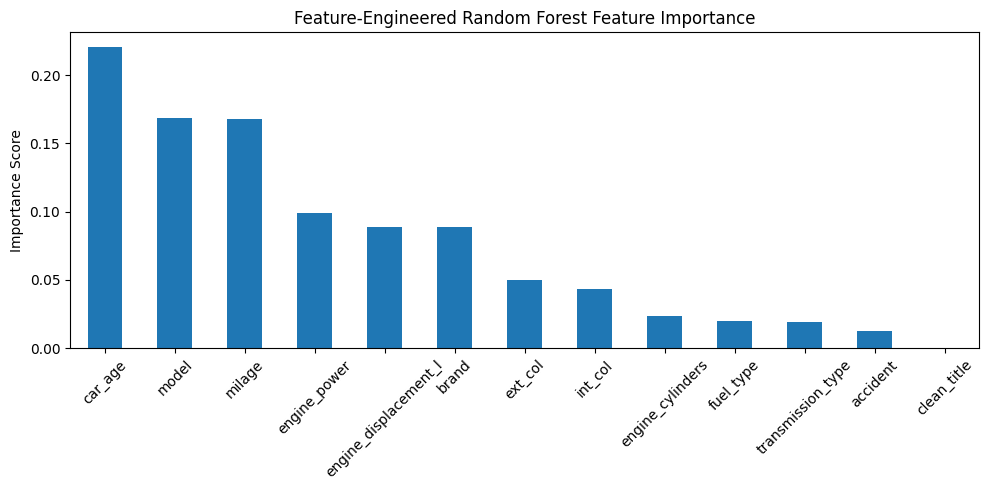

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import randint
import matplotlib.pyplot as plt

df = df_train.copy()

numeric_cols = df.select_dtypes(include=np.number).columns.drop("price")

threshold = 0.5
for col in numeric_cols:
    if abs(df[col].skew()) > threshold:
        if (df[col] <= 0).any():
            df[col] = np.log1p(df[col] - df[col].min() + 1)
        else:
            df[col] = np.log1p(df[col])

df['car_age'] = 2025 - df['model_year']
df['engine_power'] = df['engine_displacement_l'] * df['engine_cylinders']

X = df.drop(columns=["price", "model_year"])
y = df["price"]

scaler = StandardScaler()
numeric_cols_scaled = ['engine_displacement_l', 'engine_cylinders', 'int_col', 'milage', 'car_age', 'engine_power']
X_scaled = X.copy()
X_scaled[numeric_cols_scaled] = scaler.fit_transform(X_scaled[numeric_cols_scaled])

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

param_dist = {
    "n_estimators": randint(100, 500),
    "max_depth": [None, 5, 10, 15, 20],
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 5),
    "max_features": ["auto", "sqrt", "log2"]
}

rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring="r2",
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
best_rf = random_search.best_estimator_

cv_scores = cross_val_score(best_rf, X_train, y_train, cv=5, scoring="r2")
print("Cross-Validation R² Scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean())

best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

r2 = best_rf.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("\nFeature-Engineered Random Forest Performance:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mse):.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

feature_importance = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 5))
feature_importance.plot(kind="bar")
plt.title("Feature-Engineered Random Forest Feature Importance")
plt.ylabel("Importance Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


the most related features to price i.e target column are car_age, milage, model, enginepower and brand columns.